# Kats 201 - Forecasting with Kats


This tutorial will introduce time series modeling and forecasting with Kats. We will show you how to build forecasts with different Kats models and how to do parameter tuning and backtesting using Kats.  The complete table of contents for Kats 201 is as follows:

1. Forecasting with Kats Base Models     
    1.1 SARIMA     
    1.2 Prophet     
    1.3 Holt-Winters     
2. Forecasting with Kats Ensemble Model
3. Multivariate Model Forecasting
4. Hyperparameter Tuning
5. Backtesting

**Note:** We provide two types of tutorial notebooks
- **Kats 101**, basic data structure and functionalities in Kats  
- **Kats 20x**, advanced topics, such as advanced forecasting techniques (meta-learning, global model, etc.), advanced detection algorithms (Bayesian online change point detection algorithms, etc), and more.

# 1. Forecasting with Kats Base Models



In this part, we will demonstrate the forecasting workflow with the following models with `air_passengers` data set:
1. SARIMA
2. Prophet,
3. Holt-Winters


We begin by loading the `air_passengers` data set into a `TimeSeriesData` object.  This code is essentially the same as the code in our introduction to the `TimeSeriesData` object in the Kats 101 Tutorial.

In [1]:
import pandas as pd
import numpy as np
import sys
import matplotlib.pyplot as plt
import warnings

warnings.simplefilter(action='ignore')
sys.path.append("../")

from kats.consts import TimeSeriesData
air_passengers_df = pd.read_csv("../kats/data/air_passengers.csv")

# Note: If the column holding the time values is not called time, you will want to specify the name of this column.
air_passengers_df.columns = ["time", "value"]
air_passengers_ts = TimeSeriesData(air_passengers_df)

Because each of our time series models follow the `sklearn` model API pattern, the code for each of the next three examples is quite similar.  We initialize the model with its parameters and then call the `fit` and `predict` methods.  The only difference between each of these examples are the model-specific parameters.  We can then use the `plot` method to visualize our forecast in each case.

The values we choose for each of our paremeters in these examples are basically arbitrary.  Later in this tutorial, we will show you how to pick the right parameters for a model in Kats using hyperparameter tuning.

## 1.1 SARIMA

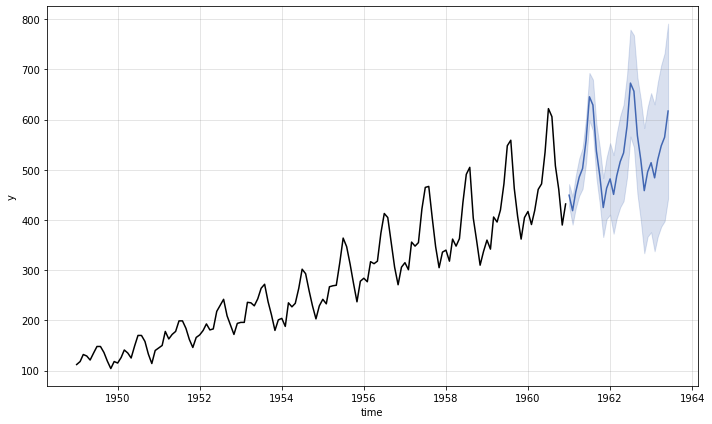

In [2]:
from kats.models.sarima import SARIMAModel, SARIMAParams
warnings.simplefilter(action='ignore')

# create SARIMA param class
params = SARIMAParams(
    p = 2, 
    d=1, 
    q=1, 
    trend = 'ct', 
    seasonal_order=(1,0,1,12)
    )

# initiate SARIMA model
m = SARIMAModel(data=air_passengers_ts, params=params)

# fit SARIMA model
m.fit()

# generate forecast values
fcst = m.predict(
    steps=30, 
    freq="MS"
    )

# make plot to visualize
m.plot()

## 1.2 Prophet

In [3]:
# import the param and model classes for Prophet model
from kats.models.prophet import ProphetModel, ProphetParams

# create a model param instance
params = ProphetParams(seasonality_mode='multiplicative') # additive mode gives worse results

# create a prophet model instance
m = ProphetModel(air_passengers_ts, params)

# fit model simply by calling m.fit()
m.fit()

# make prediction for next 30 month
fcst = m.predict(steps=30, freq="MS")

# plot to visualize
m.plot()

ModuleNotFoundError: No module named 'fbprophet'

## 1.3 Holt-Winters

In [ ]:
from kats.models.holtwinters import HoltWintersParams, HoltWintersModel
warnings.simplefilter(action='ignore')


params = HoltWintersParams(
            trend="add",
            #damped=False,
            seasonal="mul",
            seasonal_periods=12,
        )
m = HoltWintersModel(
    data=air_passengers_ts, 
    params=params)

m.fit()
fcst = m.predict(steps=30, alpha = 0.1)
m.plot()

# 2. Forecasting with Ensemble model

`KatsEnsemble` is an ensemble forecasting model, which means it allows you to combine several different forecasting models when building a forecast.  When creating an ensemble, you specify the list of models (with parameters) that you wish to include in the ensemble, and then you choose whether to aggregate these forecasts using the median or the weighted average.  Prior to building any forecasts, the model checks for seasonality and if seasonality is detected, it performs an STL decomposition (using either additive or multiplicative decomposition, as specified by the user).  Each of the forecasting models specified to the ensemble model are only applied to the the de-seasonalized components, and after these forecasts are aggregated the result is reseasonalized.

When we initialize `KatsEnsemble`, we include a dictionary with the following components:


When specifying the parameters for the `KatsEnsemble`, you specify a list of parameters for each of the models:     
    * **models:** `EnsembleParams`, contains a list of parameters for each of the individual model parameters     
    * **aggregation:** 'str', either 'median' or 'weightedavg', how to aggregate the individual forecasts to build an ensemble      
    * **seasonality_length:** int, the length of the seasonality of the time series      
    * **decomposition_method** str, either  'multiplicative' or 'additive', the type of decomposition of the initial time series

In the example below, we use the `air_passengers` data set to build a median ensemble forecast that combines 6 different forecasting models.  We use the `EnsembleParams` object to define the parameters for each of these models.  Then generating a forecast for this ensemble is straightforward.

In [ ]:
from kats.models.ensemble.ensemble import EnsembleParams, BaseModelParams
from kats.models.ensemble.kats_ensemble import KatsEnsemble
from kats.models import (
    arima,
    holtwinters,
    linear_model,
    prophet,
    quadratic_model,
    sarima,
    theta,
)

# we need define params for each individual forecasting model in `EnsembleParams` class
# here we include 6 different models
model_params = EnsembleParams(
            [
                BaseModelParams("arima", arima.ARIMAParams(p=1, d=1, q=1)),
                BaseModelParams(
                    "sarima",
                    sarima.SARIMAParams(
                        p=2,
                        d=1,
                        q=1,
                        trend="ct",
                        seasonal_order=(1, 0, 1, 12),
                        enforce_invertibility=False,
                        enforce_stationarity=False,
                    ),
                ),
                BaseModelParams("prophet", prophet.ProphetParams()),
                BaseModelParams("linear", linear_model.LinearModelParams()),
                BaseModelParams("quadratic", quadratic_model.QuadraticModelParams()),
                BaseModelParams("theta", theta.ThetaParams(m=12)),
            ]
        )

# create `KatsEnsembleParam` with detailed configurations 
KatsEnsembleParam = {
    "models": model_params,
    "aggregation": "median",
    "seasonality_length": 12,
    "decomposition_method": "multiplicative",
}

# create `KatsEnsemble` model
m = KatsEnsemble(
    data=air_passengers_ts, 
    params=KatsEnsembleParam
    )

# fit and predict
m.fit()

# predict for the next 30 steps
fcst = m.predict(steps=30)

# aggregate individual model results
m.aggregate()

# plot to visualize
m.plot()

# 3. Multivariate Model Forecasting

Vector autoregression (VAR) is a multivariable forecasting algorithm that is supported in Kats.  Here, we show show an example of how to use the `VARModel` with the `multi_ts` data set.  We begin by loading the data set into a `TimeSeriesData` and previewing it.

In [ ]:
multi_df = pd.read_csv("../kats/data/multi_ts.csv", index_col=0)
multi_ts = TimeSeriesData(multi_df)

In [ ]:
multi_df.groupby('time').sum()[['V1', 'V2']].plot(figsize=(10, 6))
plt.show()

Now it is straightforward to build this forecast using `VARModel` and plot the results as follows.

In [ ]:
# Use VAR model to forecast this multivariate time series
from kats.models.var import VARModel, VARParams

params = VARParams()
m = VARModel(multi_ts, params)
m.fit()
fcst = m.predict(steps=90)

m.plot()
plt.show()

# 4. Hyperparameter tuning

To identify which hyperparameters to use for a specfied forecasting model, we have classes in Kats that allow you to efficiently identify the best hyperparameters.  Here we will provide an exmaple of how to do hyperparameter tuning for an ARIMA model that using the `air_passengers` data set.

In [ ]:
import kats.utils.time_series_parameter_tuning as tpt
from kats.consts import ModelEnum, SearchMethodEnum, TimeSeriesData
from kats.models.arima import ARIMAParams, ARIMAModel

from ax.core.parameter import ChoiceParameter, FixedParameter, ParameterType
from ax.models.random.sobol import SobolGenerator
from ax.models.random.uniform import UniformGenerator
warnings.simplefilter(action='ignore')

The method we use to hyperparameter-tuning is a static method called `create_search_method`.  To call this method, we need to specify the type of search we are doing and the search space for the parameters.  We specify the search space for the parameters by defining a dictionary for each parameter and combining these dictionaries into a list.  Here we are specifying that we want to look at all ARIMA(p,d,q) models where the values p, d, and q are either 1 or 2.

In [ ]:
parameters_grid_search = [
{
    "name": "p",
    "type": "choice",
    "values": list(range(1, 3)),
    "value_type": "int",
    "is_ordered": True,
},
{
    "name": "d",
    "type": "choice",
    "values": list(range(1, 3)),
    "value_type": "int",
    "is_ordered": True,
},
{
    "name": "q",
    "type": "choice",
    "values": list(range(1, 3)),
    "value_type": "int",
    "is_ordered": True,
},
]

Now, we are going to create a grid search with these parameters.  The full list of arguments of the `create_search_method` are as follows:
* **Parameters:** List[Dict], this is a list of dictionaries, where each dictionary gives the search space for a parameter      
* **selected_search_method:** SearchMethodEnum, the type of search method used to do parameter tuning
* **objective_name:** str, the nume of the objective function used for the search (this is arbitrary)

In [ ]:
parameter_tuner_grid = tpt.SearchMethodFactory.create_search_method(
    objective_name="evaluation_metric",
    parameters=parameters_grid_search,
    selected_search_method=SearchMethodEnum.GRID_SEARCH,
)

Now that we have defined our search grid, we need to define the metric we are calculating at each point on the grid.  Given a set of parameters p, q, and d, we define our evaluation function to be mean absolute error (MAE) of the forecast for the test data set (using an 80/20 training-test split) using these respective parameters.

In [ ]:
# Divide into an 80/20 training-test split
split = int(0.8*len(air_passengers_df))

train_ts = air_passengers_ts[0:split]
test_ts = air_passengers_ts[split:]

# Fit an ARIMA model and calculate the MAE for the test data
def evaluation_function(params):
    arima_params = ARIMAParams(
        p = params['p'],
        d = params['d'],
        q = params['q']
    )
    model = ARIMAModel(train_ts, arima_params)
    model.fit()
    model_pred = model.predict(steps=len(test))
    error = np.mean(np.abs(model_pred['fcst'].values - test_ts.value.values))
    return error

Now that we have our grid and our evaluation functions defined, we can display our evaluation metric for each point on the grid using the following function calls.

In [ ]:
parameter_tuner_grid.generate_evaluate_new_parameter_values(
    evaluation_function=evaluation_function
)

# Retrieve parameter tuning results

parameter_tuning_results_grid = (
    parameter_tuner_grid.list_parameter_value_scores()
)

parameter_tuning_results_grid

From the calculations in the table above, we can conclude that ARIMA(2,1,1) has the minimal error of 52.02.

# 5. Backtesting

Kats provides a backtesting module that makes it easy to to compare an evaluate different forecasting models.  While our hyperparameter tuning module allows you to compare different sets of parameters for a single base forecasting model, backtesting allows you to compare different types of base models (with pre-specified parameters).  

Our backtesting module allows you to look at multiple error metrics in a single function call.  Here are the error metrics that are currently supported:
* Mean Absolute Error (MAE)
* Mean Absolute Percentage Error (MAPE)
* Symmetric Mean Absolute Percentage Error (SMAPE)
* Mean Squared Error (MSE)
* Mean Absolute Scaled Error (MASE)
* Root Mean Squared Error (RMSE)

Our example below shows how you can use the `BackTesterSimple` class to compare errors between an ARIMA model and a Prophet model using the `air_passengers` data set.

In [6]:
from kats.utils.backtesters import BackTesterSimple
from kats.models.arima import ARIMAModel, ARIMAParams

backtester_errors = {}

Here, we define a backtester to look at each of the supported error metrics for an ARIMA(2,1,1) model.  We specify in the `BackTesterSimple` definition that we are using a 75/25 training-test split to train and evaluate the metrics for this model

In [11]:
params = ARIMAParams(p=2, d=1, q=1)
ALL_ERRORS = ['mape', 'smape', 'mae', 'mase', 'mse', 'rmse']

backtester_arima = BackTesterSimple(
    error_methods=ALL_ERRORS,
    data=air_passengers_ts,
    params=params,
    train_percentage=75,
    test_percentage=25, 
    model_class=ARIMAModel)

backtester_arima.run_backtest()

After we run the backtester, the `errors` attribute will be a dictionary mapping each error type name to a its corresponding value

In [12]:
backtester_errors['arima'] = {}
for error, value in backtester_arima.errors.items():
    backtester_errors['arima'][error] = value

Now we run another backteseter to caluculate the same error metrics for a Prophet model.

In [ ]:
params_prophet = ProphetParams(seasonality_mode='multiplicative') # additive mode gives worse results

backtester_prophet = BackTesterSimple(
    error_methods=ALL_ERRORS,
    data=air_passengers_ts,
    params=params_prophet,
    train_percentage=75,
    test_percentage=25, 
    model_class=ProphetModel)

backtester_prophet.run_backtest()

backtester_errors['prophet'] = {}
for error, value in backtester_prophet.errors.items():
    backtester_errors['prophet'][error] = value

Here we can compare the error metrics for the two models.

In [ ]:
pd.DataFrame.from_dict(backtester_errors)